<a href="https://colab.research.google.com/github/WanjohiWanjohi/NLP/blob/master/NLP_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
result = pd.read_csv('sample_submission.csv')

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
#Let's see how much of our data is missing !
(train.isnull().sum()[train.isnull().sum()>0]/len(train))*100
pd.DataFrame({'Test Data Missing':(test.isnull().mean()*100).sort_values(ascending=False)})

,Test Data Missing
location,33.864542
keyword,0.796813
text,0.000000
id,0.000000


In [13]:
#looking at examples of non disaster
non_dis = train[train.target==0]['text']
non_dis

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [16]:
#looking at examples of tweets talking about a disaster
dis=train[train.target==1]['text']
dis

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

In [19]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Visualization

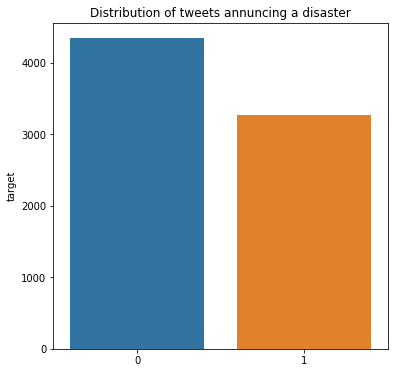

In [22]:
plt.figure(figsize=(6,6))
plt.title('Distribution of tweets annuncing a disaster')
sns.barplot(train.target.value_counts().index,train.target.value_counts())

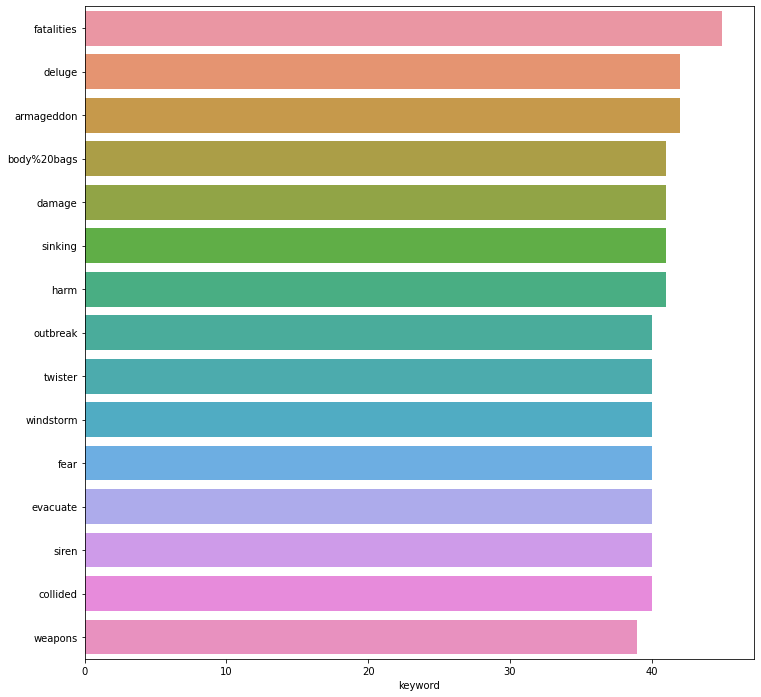

In [27]:
#of the keywords, lets us count the unique values
train.keyword.nunique()
plt.figure(figsize=(12,12))
#top 15 words used
sns.barplot(y=train.keyword.value_counts().index[:15],x=train.keyword.value_counts()[:15])

3341


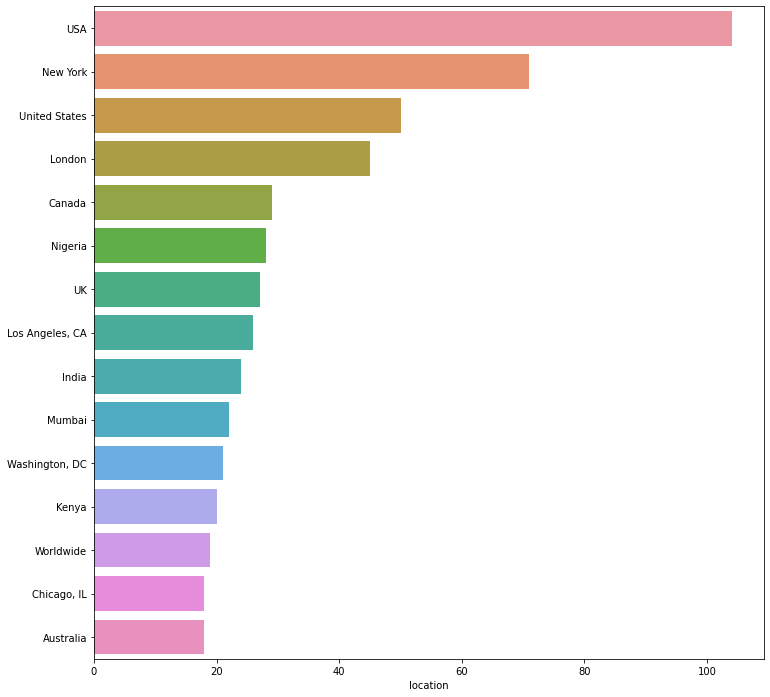

In [26]:
print(train.location.nunique())

#top 15 locations
plt.figure(figsize=(12,12))
sns.barplot(y=train.location.value_counts().index[:15],x=train.location.value_counts()[:15])

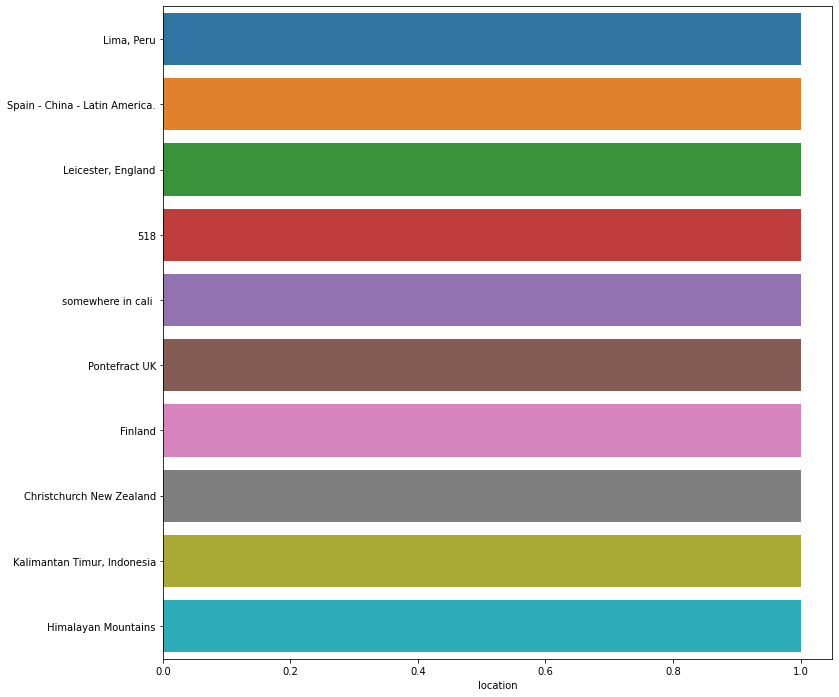

In [30]:
#least occuring locations
plt.figure(figsize=(12,12))
sns.barplot(y=train.location.value_counts().index[-10:],x=train.location.value_counts()[-10:])

## Preprocessin

In [36]:
#start with cleaning data noise such as case : use regex
def lowercase_text(text):
    return text.lower()
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [32]:
#apply lowercase fxn to text column of train and test
train.text=train.text.apply(lambda x: lowercase_text(x))
test.text=test.text.apply(lambda x: lowercase_text(x))

In [37]:
#apply remove nouise fxn on test and train data
train.text=train.text.apply(lambda x: remove_noise(x))
test.text=test.text.apply(lambda x: remove_noise(x))

In [38]:
!pip install nlppreprocess

### NLP Preprocessing

In [39]:
from nlppreprocess import NLP

In [40]:
nlp = NLP()

train['text'] = train['text'].apply(nlp.process)
test['text'] = test['text'].apply(nlp.process)

Stemming

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [43]:
stemmer = SnowballStemmer("english")
def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)

Text(0.5, 1.0, 'Frequent Words')

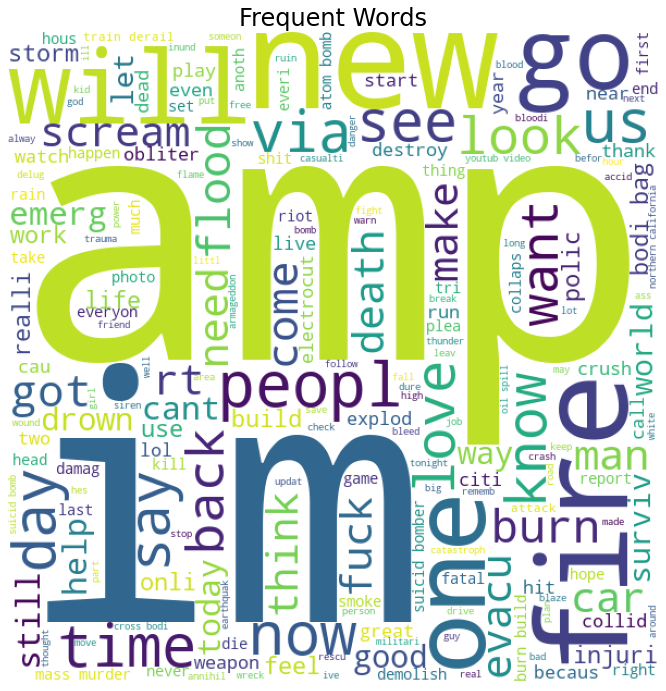

In [45]:
from wordcloud import WordCloud
fig , ax1 = plt.subplots(1,figsize=(12,12))
wordcloud=WordCloud(background_color='white',width=600,height=600).generate(" ".join(train.text))
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('Frequent Words',fontsize=24)

## Encoding